<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/04_Interpretable_AI_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 03

#Description: Interpretable AI
This notebook is for exploring interpretable models using imodels (https://github.com/csinva/imodels?tab=readme-ov-file). Imodels is a Python package containing models for concise, transparent, and accurate predictive modeling. The dataset being explored is:

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/04_Interpretable_AI_part2.ipynb)

Acknowledgements: Class Repository code on GAM model, kaggle telco-customer-churn dataset

In [ ]:
import os

# Remove Colab default sample_data
!rm -r /content/sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-XAI"
git_path = 'https://github.com/mille055/AIPI590-XAI.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"


notebook_dir = 'Assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 123 (delta 71), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 1.57 MiB | 5.47 MiB/s, done.
Resolving deltas: 100% (71/71), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
## Standard libraries
import json
import math
import time
import numpy as np
import tabulate
import urllib.request
import zipfile
import pandas as pd

## Imports for data exploration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Imports for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


## Imports for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Imports for GAM
from pygam import LogisticGAM, LinearGAM, GammaGAM, s

## Imports for imodels
from imodels import get_clean_dataset
from imodels import SLIMClassifier, OneRClassifier, BoostedRulesClassifier, FIGSClassifier, HSTreeClassifierCV
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor, GreedyRuleListClassifier
from imodels.discretization import ExtraBasicDiscretizer, EqualWidthDiscretizer, EqualFrequencyDiscretizer, DecisionTreeDiscretizer

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet




In [ ]:
# Get secrets if necessary
# from google.colab import userdata
# userdata.get('secretName')

In [ ]:
# Get device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('device is ', device)

device is  cuda:0


In [ ]:
# Define the paths where the zip files will be downloaded and extracted
DATA_PATH = 'AIPI590-XAI/Assignments/data/DATASET'

# Download the datafile and convert to pandas
churn_df = pd.read_csv(DATA_PATH)
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis

customerID : Customer ID

gender : Male or a female customer

SeniorCitizen : Whether the customer is a senior citizen or not (1, 0)

Partner : Whether the customer has a partner or not (Yes, No)

Dependents : Whether the customer has dependents or not (Yes, No)
tenure : Number of months the customer has stayed with the company

tenure: Number of months with service

PhoneService : Whether the customer has a phone service or not (Yes, No)

MultipleLines : Whether the customer has multiple lines or not (Yes, No, No phone service)

InternetService : Customer’s internet service provider (DSL, Fiber optic, No)

OnlineSecurity : Whether the customer has online security or not (Yes, No, No internet service)

OnlineBackup : Whether the customer has online backup or not (Yes, No, No internet service)

DeviceProtection : Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport : Whether the customer has tech support or not (Yes, No, No internet service)

StreamingTV : Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies : Whether the customer has streaming movies or not (Yes, No, No internet service)

Contract : The contract term of the customer (Month-to-month, One year, Two year)

PaperlessBilling : Whether the customer has paperless billing or not (Yes, No)

PaymentMethod : The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

MonthlyCharges : The amount charged to the customer monthly

TotalCharges : The total amount charged to the customer

Churn : Whether the customer churned or not (Yes or No)

Shape:
 (7043, 20)
Describe:
                  count         mean          std    min    25%      50%  \
SeniorCitizen   7043.0     0.162147     0.368612   0.00    0.0     0.00   
tenure          7043.0    32.371149    24.559481   0.00    9.0    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.5    70.35   
TotalCharges    7043.0  2279.581350  2264.729447   0.00  394.0  1393.60   

                    75%      max  
SeniorCitizen      0.00     1.00  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.10  8550.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 no

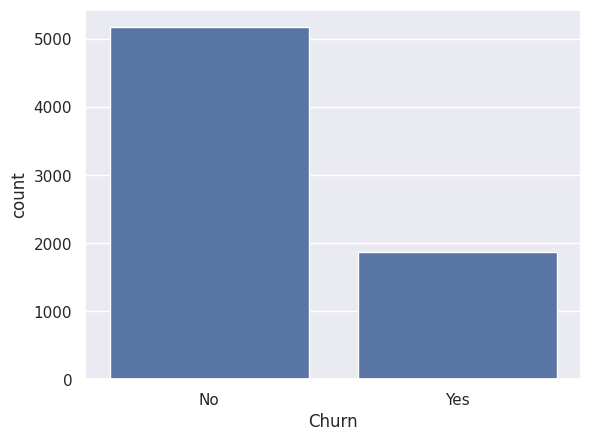


Churn:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn rate: 
 0.27

ValuCounts:

gender
Male      3555
Female    3488
Name: count, dtype: int64


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


OnlineBackup
No                     3088
Yes                    2429
No internet 

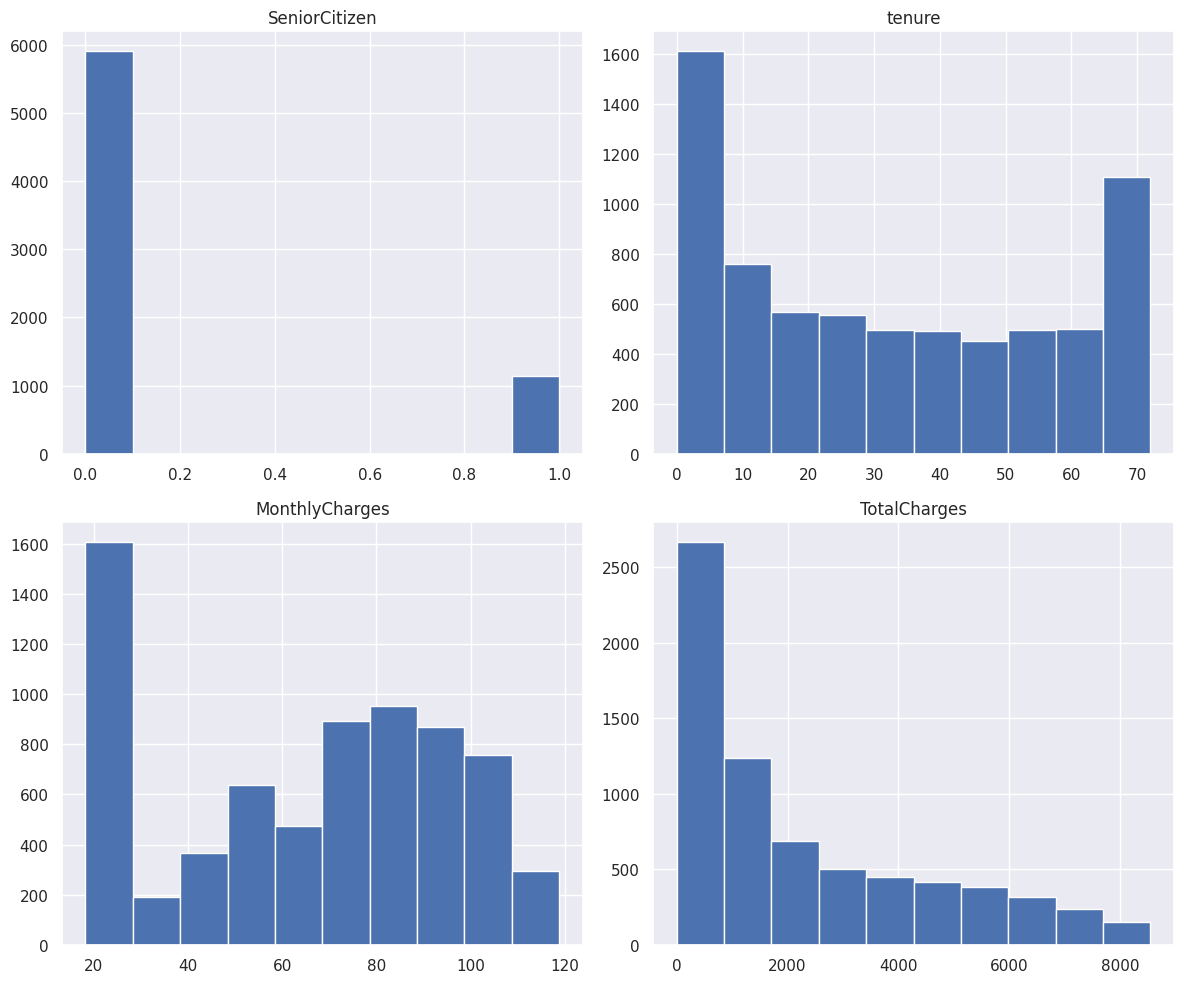

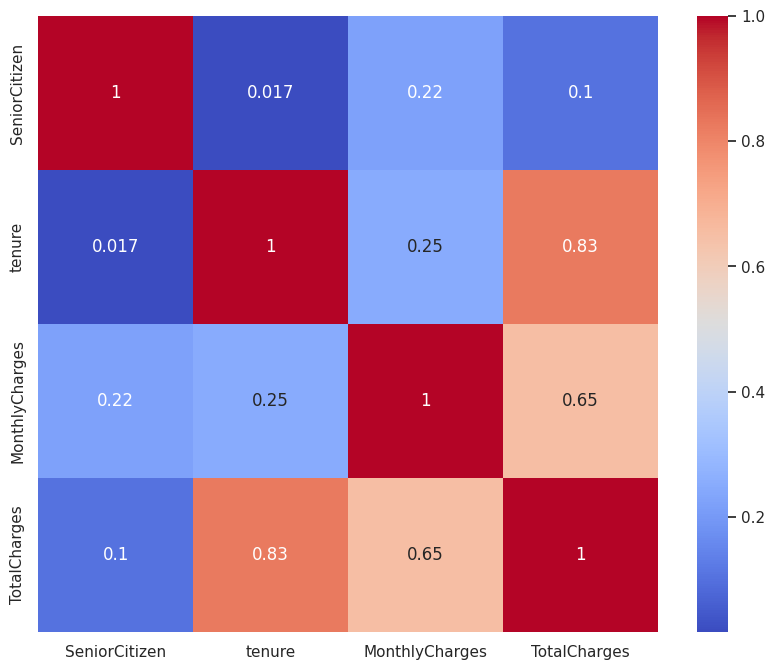


Pairplot:



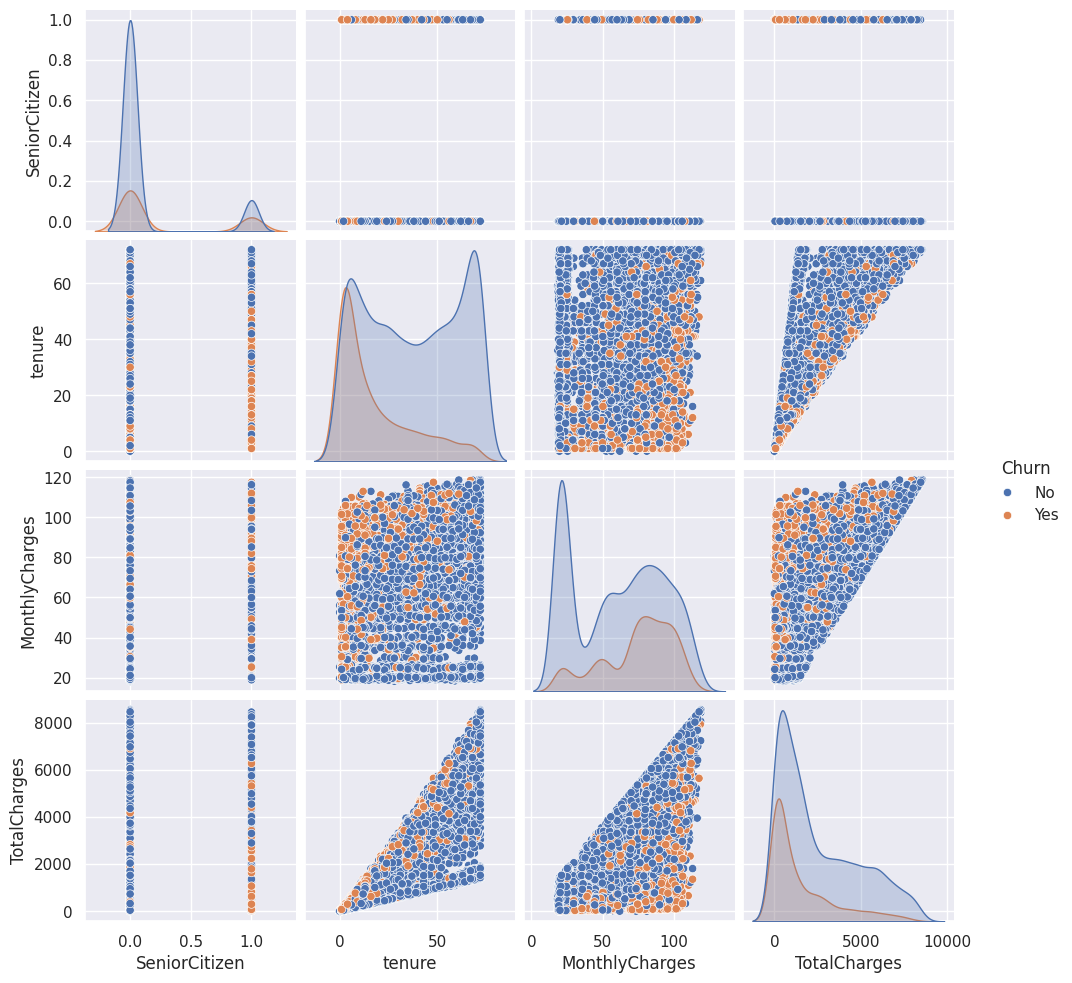


Colinearity Check:

          Feature        VIF
0           const  14.996787
1   SeniorCitizen   1.054522
2          tenure   5.885955
3  MonthlyCharges   3.327876
4    TotalCharges   9.612501


In [ ]:
# Check multicollinearity using Variance Inflation Factor (VIF)
def check_multicollinearity(df):
  X = df.select_dtypes(include=[float, int])  # Select only numeric features

  # Add constant for the intercept term
  X = sm.add_constant(X)

  # Calculate VIF
  vif_data = pd.DataFrame()
  vif_data['Feature'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  print(vif_data)


def EDA(df):
  df1= df.copy()
  df1.drop('customerID', axis=1, inplace=True)
  #print("Head:\n", df1.head())
  df1.TotalCharges = df1.MonthlyCharges*df1.tenure
  print("Shape:\n", df1.shape)
  print("Describe:\n", df1.describe().T)
  print("\nInfo:\n", df1.info())
  print("\nShape:\n", df1.shape)
  print("\nNull Values:\n", df1.isnull().sum())
  print("\nColumns:\n", df1.columns)
  # Visualize distribution of churn
  sns.countplot(x='Churn', data=df1)
  plt.show()
  print("\nChurn:\n", df1['Churn'].value_counts())
  print("\nChurn rate: \n", round(((df1['Churn']=='Yes').sum()/len(df1)),2))
  print("\nValuCounts:\n")
  for col in df1.columns:
    print(df1[col].value_counts())
    print("\n")


  # Visualize numerical features
  df1.hist(figsize=(12,10))
  plt.tight_layout()
  plt.show()

  # Correlation matrix for numerical features after dropping any non-numeric columns

  df1_numeric = df1.select_dtypes(include=['float64', 'int64'])
  corr_matrix = df1_numeric.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
  plt.show()


  # Pairplot
  print('\nPairplot:\n')
  sns.pairplot(df1, hue='Churn')
  plt.show()

  # Check colinearity
  print('\nColinearity Check:\n')
  check_multicollinearity(df1)


EDA(churn_df)

## Learned from the EDA:
There are several points to take away from the EDA, including:

1. It is an unbalanced dataset with regards to churn, with more that stay than churn by about 3:1.
2. Three numerical features: MonthlyCharges, TotalCharges, and SeniorCitizen (although this is just an encoded categorical category).
3. Large number of categorical features.
4. TotalCharges displays a positively or rightly skewed distribution.
5. Looking at tenure, highest number churn at 1 month, and most leave within the first 4 months.

## Linear Regression

In [ ]:
# Select relevant features for linear regression
features = ['tenure', 'MonthlyCharges', 'TotalCharges']
target = 'Churn'

# Create a new DataFrame with selected features and target variable
df_linear = churn_df[features + [target]]

# Make TotalCharges numeric
df_linear['TotalCharges'] = pd.to_numeric(df_linear['TotalCharges'], errors='coerce')

# Drop rows with missing values
df_linear.dropna(inplace=True)

# # Convert 'Churn' to numeric (1 for Yes, 0 for No)
df_linear['Churn'] = df_linear['Churn'].map({'Yes': 1, 'No': 0})


<ipython-input-8-eb3a515b697d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linear['TotalCharges'] = pd.to_numeric(df_linear['TotalCharges'], errors='coerce')
<ipython-input-8-eb3a515b697d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linear.dropna(inplace=True)
<ipython-input-8-eb3a515b697d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     553.7
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          2.88e-315
Time:                        09:27:48   Log-Likelihood:                -2657.7
No. Observations:                5625   AIC:                             5323.
Df Residuals:                    5621   BIC:                             5350.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2658      0.005     51.342      0.0

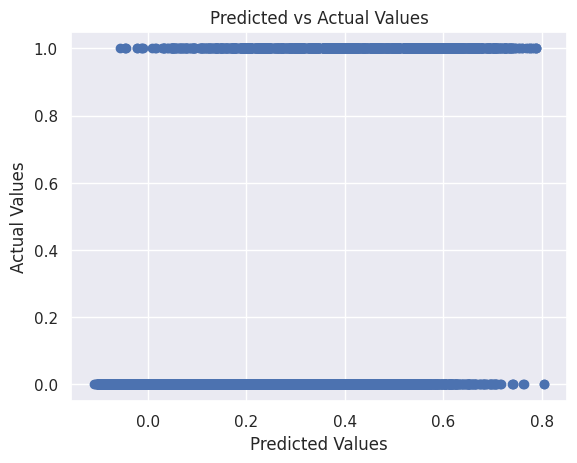

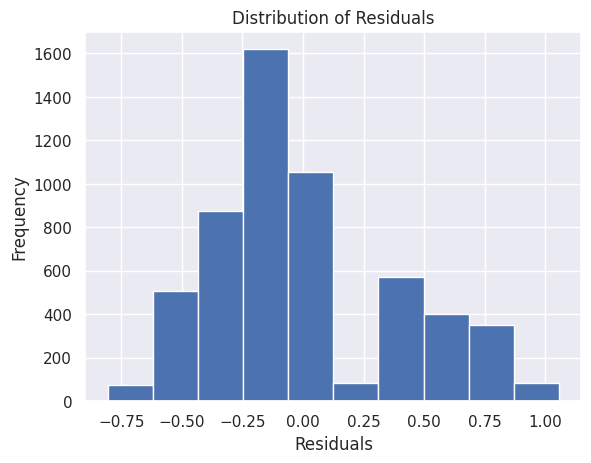

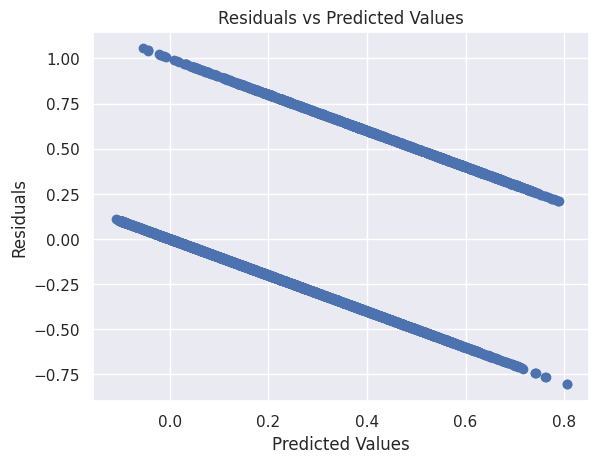

          Feature        VIF
0           const  15.004971
1          tenure   5.875290
2  MonthlyCharges   3.525402
3    TotalCharges   9.719105
4           Churn   1.289745
None


In [ ]:
# Linear regression

# Split the data into features (X) and target (y)
X = df_linear[features]
y = df_linear['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Add constant to the features for the intercept term
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the linear regression model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

# Check for linearity
# Plot predicted values against actual values
plt.scatter(model.predict(X_train), y_train)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')
plt.show()

# Check for normality of residuals
residuals = model.resid
plt.hist(residuals)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Check for homoscedasticity
plt.scatter(model.predict(X_train), residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Check for multicollinearity
print(check_multicollinearity(df_linear))

## Comments on linear regression:
1. The R-squared value is low (0.228): This indicates that the model explains only 22.8% of the variance in the target variable (Churn). For linear regression, this is quite low, meaning the linear model does not capture much of the variation in the data. It suggests that a linear model might not be the best choice for predicting churn.
Adjusted R-squared (0.228): The adjusted R-squared is very close to the R-squared, so adding more features is unlikely to improve the model significantly without increasing overfitting.
2. Does It Meet the Assumptions for Linear Regression?

*   **Linearity:** The relationship between the predictors and the target variable does not seem to be fully linear, as suggested by the relatively low R-squared.
*   **Normality of Residuals:** The Omnibus, Jarque-Bera, Skew, and Kurtosis statistics suggest that the residuals are not normally distributed, which can also be seen in the plots. This violates the normality assumption of linear regression.

*   **Homoscedasticity:** There is no a constant variance of residuals shown in the plot of residuals vs. fitted values.
*   **Multicollinearity:** The condition number (6.01) indicates that multicollinearity is not an issue in this model.



3. Overall assessment: Linear regression does not appear to be a good model for this dataset. One, most of the features are non-numeric and play no role in the linear regression. Secondly, the assumptions for linear regression are not met, and there is a poor R-squared value showing a bad fit of the data. Logistic regression may be a better choice.


## Logistic Regression

In [ ]:
# Make a copy of the original dataset
df_log = churn_df.copy()

# Make 'TotalCharges' numeric
df_log['TotalCharges'] = pd.to_numeric(df_log['TotalCharges'], errors='coerce')

# Drop 'customerID' as it is not relevant for the model
df_log.drop('customerID', axis=1, inplace=True)

# Drop rows with missing values
df_log.dropna(inplace=True)

# Convert 'Churn' to numeric (1 for Yes, 0 for No)
df_log['Churn'] = df_log['Churn'].map({'Yes': 1, 'No': 0})

# Identify categorical features
categorical_cols = df_log.select_dtypes(include=['object']).columns

# Apply Label Encoding for categorical columns
label_encoder = LabelEncoder()

for col in categorical_cols:
    df_log[col] = label_encoder.fit_transform(df_log[col])


# View the first few rows of the encoded DataFrame
df_log.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Accuracy: 0.785
F1-score: 0.551
Precision: 0.621
Recall: 0.495
ROC AUC: 0.831
Confusion Matrix:


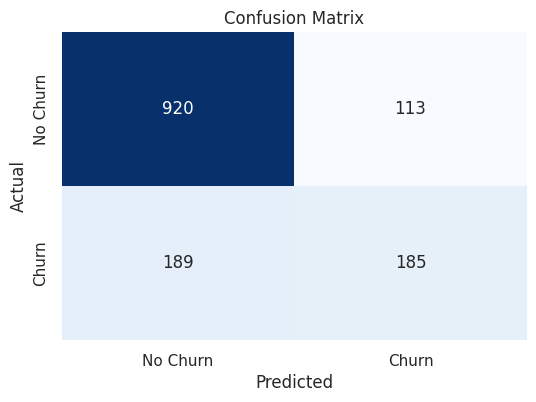

In [ ]:
# Get X and y from df_log
logX = df_log.drop('Churn', axis=1)
logy = df_log['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(logX, logy, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train the logistic regression model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]  # Predicted probabilities

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {round(accuracy,3)}")
print(f"F1-score: {round(f1, 3)}")
print(f"Precision: {round(precision,3)}")
print(f"Recall: {round(recall,3)}")
print(f"ROC AUC: {round(roc_auc,3)}")
print("Confusion Matrix:")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# logistic_model = LogisticRegression(max_iter=1000)
# logistic_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_logistic = logistic_model.predict(X_test)
# y_pred_logistic_proba = logistic_model.predict_proba(X_test)[:, 1]

# # Evaluate the models

# accuracy = accuracy_score(y_test, y_pred_logistic)
# precision = precision_score(y_test, y_pred_logistic)
# recall = recall_score(y_test, y_pred_logistic)




## Evaluiation of the logistic regression
Accuracy: An accuracy of 78.5% suggests that the model performs decently in terms of overall correctness. However, accuracy can be misleading when dealing with imbalanced datasets, where one class (e.g., "No Churn") may dominate the other (e.g., "Churn").

Precision: A precision of 0.621 means that around 62.1% of customers predicted to churn actually churned. This is a reasonable value, but there's room for improvement, as the model is still predicting a fair number of false positives (customers predicted to churn who don’t churn).

Recall: A recall of 0.495 is relatively low. This means that the model is missing a significant number of actual churn cases (about 50.5% of churns are not being predicted by the model). Low recall suggests that the model might be conservative in predicting churn. Accounting for, and addressing, the class imbalance may help.

Class Imbalance: Given the discrepancy between precision (0.621) and recall (0.495), as well as the F1-score (0.551), the model may be affected by an imbalanced dataset with regards to the target variable of "Churn". This can lead to high accuracy but poor performance in predicting the minority class.

Precision vs. Recall Tradeoff: The model is better at precision than recall, meaning it is more cautious in predicting churn (i.e., when it does predict churn, it’s more often correct), but it fails to identify many actual churn cases. This might be an issue if the business needs to maximize recall to catch more churners, even at the expense of some false positives.

Validity of Assumptions: Some of the assumptions for logistic regression include: linearity of the log-odds of the target variable with the features, independence of error terms, and lack of multicolinearity. The lack of multicolinearity was addressed above.

In [ ]:
X_train.shape

(5625, 19)

## GAM model

In [ ]:
# Assuming X_train_scaled has 19 features
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) +s(10) +s(11) +s(12) +s(13) +s(14) +s(15) +s(16) +s(17) +s(18))

# Fit the model
gam.fit(X_train, y_train)

# Find best smoothing parameters for each spline term via grid search
gam.gridsearch(X_train, y_train)

# Fit the model
gam.fit(X_train, y_train)

# Make predictions (these are probabilities)
y_pred_gam_prob = gam.predict_proba(X_test)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_gam = (y_pred_gam_prob > 0.5).astype(int)

# Evaluate the model
accuracy_gam = accuracy_score(y_test, y_pred_gam)
roc_auc_gam = roc_auc_score(y_test, y_pred_gam_prob)
conf_matrix_gam = confusion_matrix(y_test, y_pred_gam)

# Print results
print(f"GAM Accuracy: {accuracy_gam:.4f}")
print(f"GAM ROC AUC: {roc_auc_gam:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gam)
print("\n")

# Show GAM summary
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:12 Time:  0:00:12


GAM Accuracy: 0.7932
GAM ROC AUC: 0.8355
Confusion Matrix:
[[932 101]
 [190 184]]


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     33.7234
Link Function:                        LogitLink Log Likelihood:                                 -2262.9212
Number of Samples:                         5625 AIC:                                             4593.2893
                                                AICc:                                            4593.7332
                                                UBRE:                                               2.8214
                                                Scale:                                                 1.0
                                                Pseudo R-Squ

<ipython-input-13-6dd334818cf9>:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


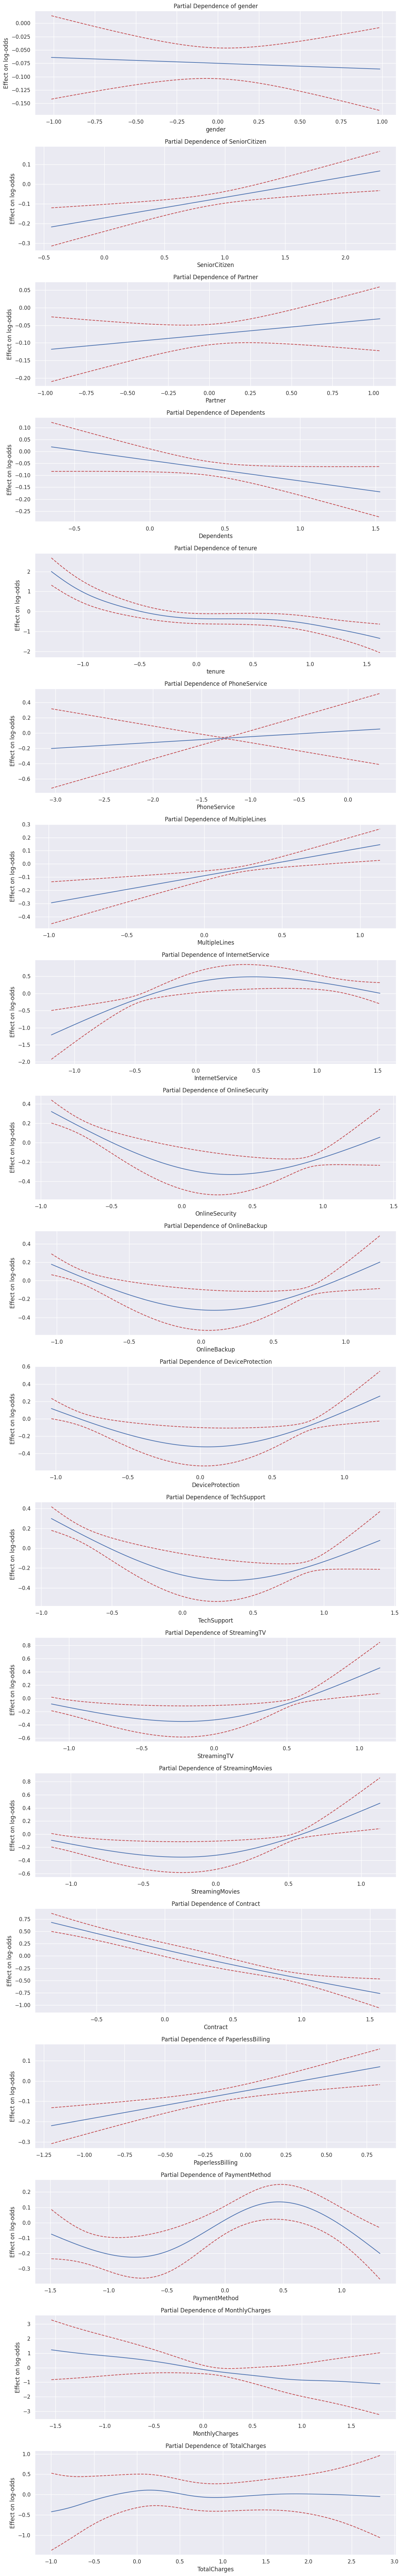

In [ ]:
# Number of features
num_features = X_train.shape[1]
#print(f"Num features is {num_features}")

# Plot the partial dependence for each feature
fig, axs = plt.subplots(num_features, 1, figsize=(12, num_features * 4))

# Loop through each feature
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(f'Partial Dependence of {df_log.columns[i]}')
    ax.set_xlabel(df_log.columns[i])
    ax.set_ylabel('Effect on log-odds')

plt.tight_layout()
plt.show()

## Evaluation of the GAM model and comparison with the baseline models (linear regression and log regression)

1. Accuracy: The model correctly predicts churn and non-churn cases around 79.3% of the time. While decent, this suggests that there is still a portion of churners and non-churners that the model struggles to predict correctly. This value is similar to that on the logistic regression model.

2. ROC AUC: The ROC AUC score of 0.8355 indicates good discriminatory power. This means the model can distinguish between churners and non-churners relatively well. This value is comparable to that of the logistic regression model.

3. The pseudo R-squared value of 0.305 indicates that the model explains 30.5% of the variance in the churn outcome. For classification tasks, this is a reasonable value and suggests that the model captures some, but not all, of the underlying patterns. This value is a little higher than that for the linear regression model.

4. Features: Several features, such as s(1), s(4), s(6), s(7), s(8), and s(9), show high significance (p < 0.001), indicating that these features have a strong non-linear relationship with churn. The partial dependence plots are shown above. The features that seem to show significant correlation are SeniorCitizens, tenure, contract, MultipleLines, PaperlessBilling; additionally, MonthlyCharges has negative correlation with staying.

## Strengths/weaknesses of Each Model:

Linear Regression:
Strengths include simplicity and ease in interpretation. However, it is not ideal for binary classification and a poor fit for non-linear data.

Logistic Regression:
Strengths incluee easy to interpret (coefficients directly relate to log-odds). Works well for binary classification. However, weaknesses include limited in capturing non-linearity.

Generalized Additive Model (GAM):
Strengths include great for capturing non-linear relationships.
Partial dependence plots can make the model interpretable by showing the smooth relationships between each feature and the target. However, P-values from the model need careful interpretation due to potential issues with smoothing parameters.


## Recommendations:
If Interpretability is Key: Both logistic regression and GAM offer interpretability, but GAM is preferred if you suspect non-linear relationships in the data, and partial dependence plots can provide insights into feature effects.

If Prediction Performance is the Priority: The GAM model has the highest ROC AUC, showing strong predictive ability, especially in handling non-linear data. However, the slightly lower recall suggests it might miss some churners, so further tuning or balancing techniques might be needed.

Logistic Regression is a strong baseline for binary classification tasks and may work well if the data does not exhibit significant non-linearity.

Linear Regression is generally not appropriate for churn prediction because it treats churn as a continuous variable, which is unsuitable for binary classification.
